In [1]:
# Kütüphaneler
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from scipy import stats 

In [2]:
# Bilgisayar için olan uyarıları kapatma
os.environ["LOKY_MAX_CPU_COUNT"] = "10"  # Gerçek çekirdek sayını yaz

# Veri setini yükleyin
df = pd.read_csv("kc_house_data.csv")

# Veri setinin boyutunu kontrol edin
print(f"Veri seti boyutu: {df.shape}")

# Eksik değerleri kontrol edin
print(f"Eksik değerler: {df.isnull().sum().sum()}")

Veri seti boyutu: (21613, 21)
Eksik değerler: 0


In [3]:
# ----------------------------
# Veri Ön İşleme
# ----------------------------

# Date sütununu datetime formatına dönüştürme
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Ev yaşı hesaplama
df['house_age'] = 2023 - df['yr_built']

# One-Hot Encoding (OHE) - zipcode için - Çok fazla sütun oluşturduğu için blockladım 
# df = pd.get_dummies(df, columns=['zipcode'], drop_first=True)
    
# Fiyat kategorileri 
df['price_category'] = pd.cut(df['price'], 
                             bins=[0, 300000, 500000, 750000, float('inf')],
                             labels=['Düşük', 'Orta', 'Yüksek', 'Premium'])

# Oda başına metrekare (0'a bölme hatasını önle)
df['sqft_per_room'] = df['sqft_living'] / (df['bedrooms'] + df['bathrooms'] + 1)

# Yaşam alanı oranları
df['living_lot_ratio'] = df['sqft_living'] / df['sqft_lot']
df['above_total_ratio'] = df['sqft_above'] / df['sqft_living']

# Yenilenme durumu
df['is_renovated'] = (df['yr_renovated'] > 0).astype(int)

# Waterfront ve view kombinasyonu
df['premium_location'] = ((df['waterfront'] == 1) | (df['view'] > 2)).astype(int)

# Ev büyüklük kategorisi
df['house_size'] = pd.cut(df['sqft_living'], 
                         bins=[0, 1500, 2500, 4000, float('inf')],
                         labels=[1, 2, 3, 4])  
df['house_size'] = df['house_size'].astype(int)  

# Kat oranı
df['floors_ratio'] = df['floors'] / df['sqft_living'] * 1000  # Normalize için

In [17]:
# 1. OUTLIER ANALİZİ
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

print("\n--- OUTLIER ANALİZİ ---")
price_outliers = detect_outliers(df, 'price')
print(f"Fiyat outlier'ları: {len(price_outliers)} adet")



--- OUTLIER ANALİZİ ---
Fiyat outlier'ları: 1146 adet


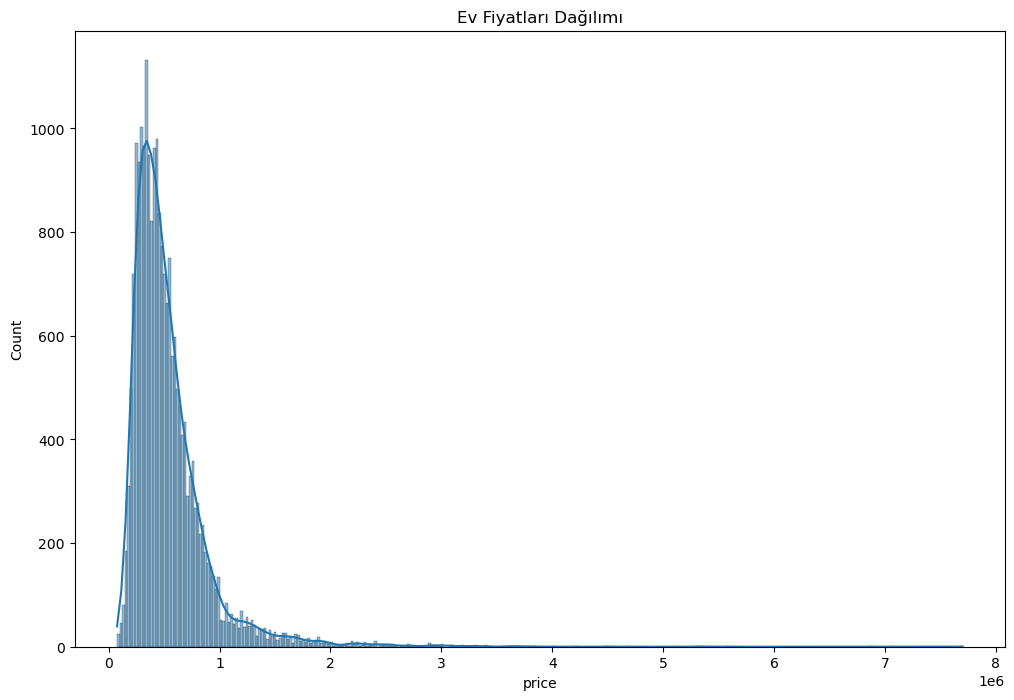

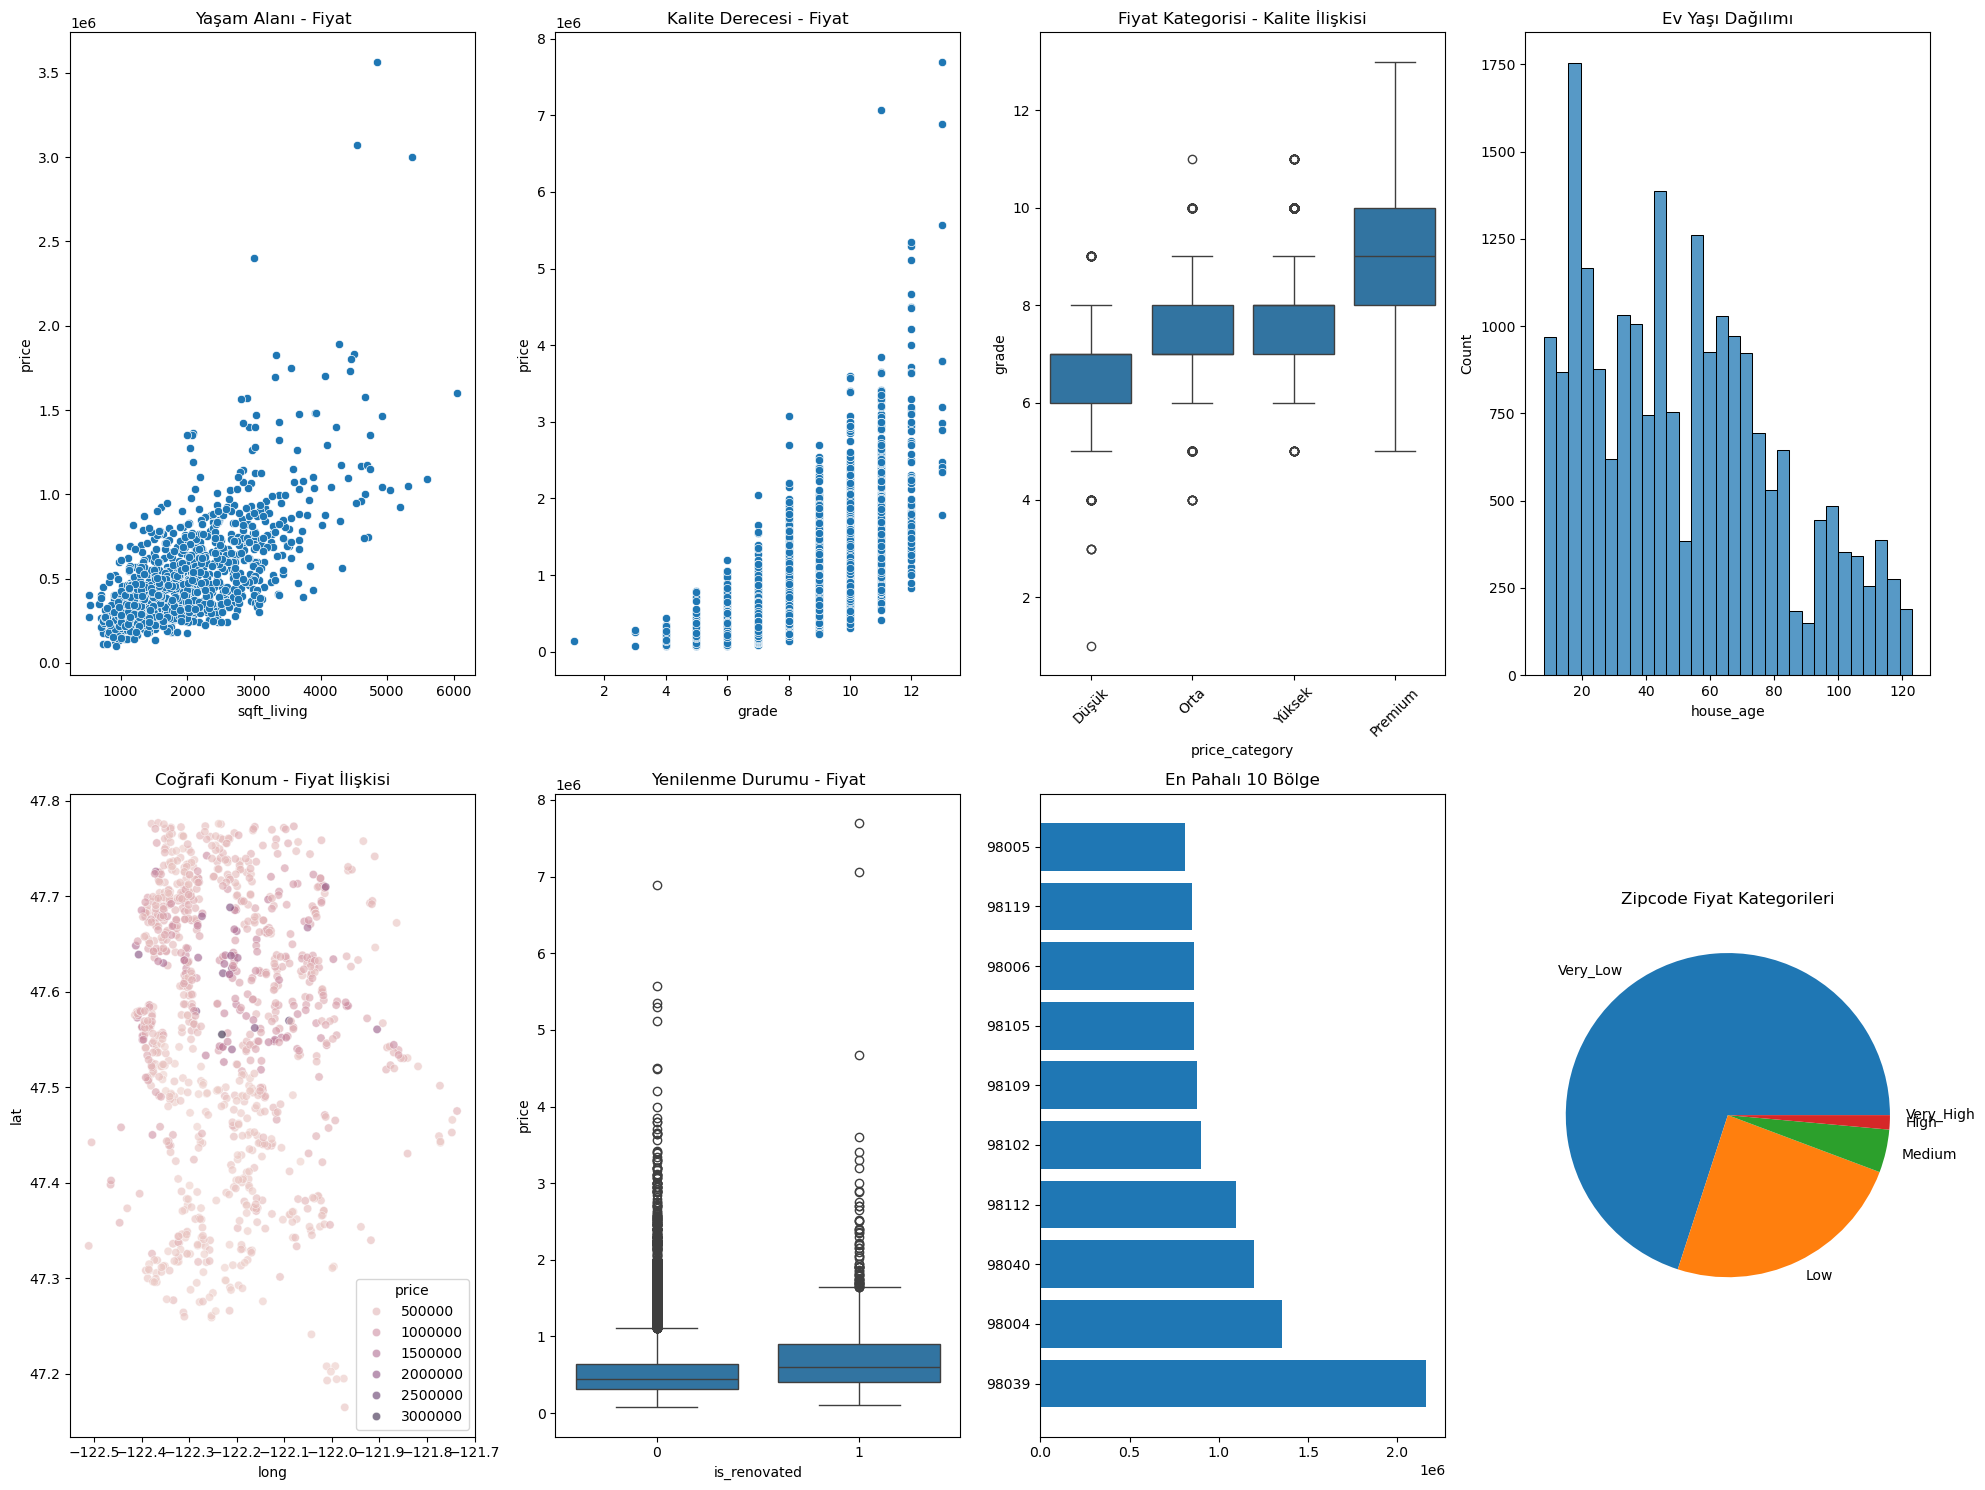

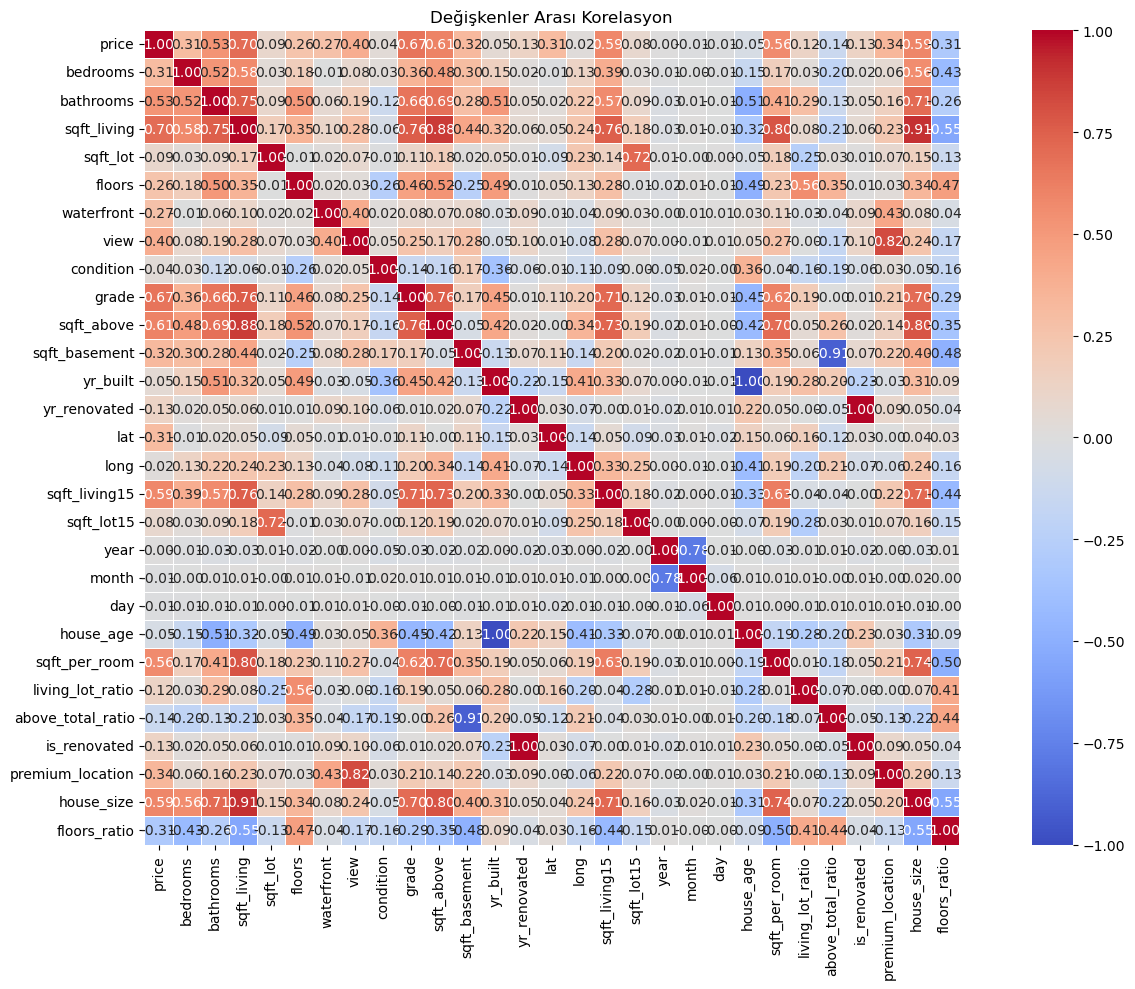


Özellik sayısı: 28
Kullanılan özellikler: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year', 'month', 'day', 'house_age', 'sqft_per_room', 'living_lot_ratio', 'above_total_ratio', 'is_renovated', 'premium_location', 'house_size', 'floors_ratio']


In [5]:
# ----------------------------
# Veri Görselleştirme
# ----------------------------

# Ev Fiyatları Dağılımı (TEK BAŞINA)
plt.figure(figsize=(12, 8))
sns.histplot(df['price'], kde=True)
plt.title('Ev Fiyatları Dağılımı')
plt.show()

# Detaylı Görselleştirmeler
plt.figure(figsize=(20, 15))

plt.subplot(2, 4, 1)
sns.scatterplot(x='sqft_living', y='price', data=df.sample(1000))
plt.title('Yaşam Alanı - Fiyat')

plt.subplot(2, 4, 2)
sns.scatterplot(x='grade', y='price', data=df)
plt.title('Kalite Derecesi - Fiyat')

plt.subplot(2, 4, 3)
sns.boxplot(data=df, x='price_category', y='grade')
plt.title('Fiyat Kategorisi - Kalite İlişkisi')
plt.xticks(rotation=45)

plt.subplot(2, 4, 4)
sns.histplot(df['house_age'], bins=30)
plt.title('Ev Yaşı Dağılımı')

plt.subplot(2, 4, 5)
sns.scatterplot(data=df.sample(1000), x='long', y='lat', hue='price', alpha=0.6)
plt.title('Coğrafi Konum - Fiyat İlişkisi')

plt.subplot(2, 4, 6)
sns.boxplot(data=df, y='price', x='is_renovated')
plt.title('Yenilenme Durumu - Fiyat')

plt.subplot(2, 4, 7)

# En pahalı 10 zipcode
top_zipcodes = df.groupby('zipcode')['price'].mean().nlargest(10)
plt.barh(range(10), top_zipcodes.values)
plt.yticks(range(10), top_zipcodes.index)
plt.title('En Pahalı 10 Bölge')

plt.subplot(2, 4, 8)

# Zipcode kategorilerinin dağılımı
zipcode_cat_counts = df.groupby('zipcode')['price'].mean()
zipcode_cat_counts = pd.cut(zipcode_cat_counts, bins=5).value_counts()
plt.pie(zipcode_cat_counts.values, labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'])
plt.title('Zipcode Fiyat Kategorileri')

plt.tight_layout()
plt.show()

# Korelasyon analizi (MEVCUT KODUN YERİNE)
plt.figure(figsize=(15, 10))
numeric_df = df.select_dtypes(include=[np.number])
# Kategorik sütunları çıkar
numeric_df = numeric_df.drop(['id', 'zipcode'], axis=1, errors='ignore')
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, 
            fmt='.2f', square=True)
plt.title('Değişkenler Arası Korelasyon')
plt.tight_layout()
plt.show()

# ----------------------------
# Eğitim ve test verisine ayırma 
# ----------------------------

from sklearn.model_selection import train_test_split

# Gereksiz sütunları çıkar
columns_to_drop = ['price', 'id', 'date', 'zipcode', 'price_category']  
X = df.drop(columns_to_drop, axis=1, errors='ignore')
y = df['price']

print(f"\nÖzellik sayısı: {X.shape[1]}")
print(f"Kullanılan özellikler: {list(X.columns)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Regresyon için Gerekli Kütüphaneler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

# Özellik Ölçeklendirme
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modellerin Tanımlanması
models = {
    'Doğrusal Regresyon': LinearRegression(),
    'Ridge Regresyon': Ridge(alpha=1.0),
#    'Lasso Regresyon': Lasso(alpha=0.5, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=1.0, max_iter=10000),
    'SVR': SVR(kernel='linear',C=1.0,epsilon=0.1),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5),
    'Karar Ağacı': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Rastgele Orman': RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=-1),
    'Gradyan Arttırma': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Hangi modellerin ölçeklendirme gerektirdiğini belirle
scaled_models = {
    'Doğrusal Regresyon',
    'Ridge Regresyon',
#    'Lasso Regresyon',
    'ElasticNet',
    'SVR',
    'KNN Regressor'
}

# Model performans karşılaştırma için sonuçlar
results = {}

# Model Eğitimi ve Değerlendirme
for name, model in models.items():
    print(f"{name} eğitiliyor...")
    start_time = time.time()
    
    if name in scaled_models:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

    # Performans hesaplama
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    cv_r2_mean = cv_scores.mean()
    cv_r2_std = cv_scores.std()

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'CV R2 (Ortalama)': cv_r2_mean,
        'CV R2 (Std Sapma)': cv_r2_std
    }

    end_time = time.time()
    train_time = end_time - start_time
    results[name]['Eğitim Süresi (s)'] = train_time

    print(f"{name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, "
          f"R2: {r2:.4f}, CV R2: {cv_r2_mean:.4f} (+/- {cv_r2_std:.4f}), "
          f"Eğitim Süresi: {train_time:.2f} sn\n")

# En iyi modeli R2 skoruna göre seç
best_model_name = max(results, key=lambda x: results[x]['R2'])
second_best_name = sorted(results.items(), key=lambda x: x[1]['R2'], reverse=True)[1][0]
print(f"\n🚀 En iyi model: {best_model_name} (R2: {results[best_model_name]['R2']:.4f})")
# İlerdeki karşılaştırma tablosu için 
previous_metrics = results[best_model_name]


Doğrusal Regresyon eğitiliyor...
Doğrusal Regresyon - MAE: 125793.68, MSE: 44021898571.05, RMSE: 209813.96, R2: 0.7088, CV R2: 0.7013 (+/- 0.0363), Eğitim Süresi: 1.78 sn

Ridge Regresyon eğitiliyor...
Ridge Regresyon - MAE: 126124.11, MSE: 44236574637.60, RMSE: 210324.93, R2: 0.7074, CV R2: 0.7009 (+/- 0.0357), Eğitim Süresi: 1.40 sn

ElasticNet eğitiliyor...
ElasticNet - MAE: 131456.84, MSE: 56099215028.01, RMSE: 236852.73, R2: 0.6289, CV R2: 0.6382 (+/- 0.0228), Eğitim Süresi: 0.24 sn

SVR eğitiliyor...
SVR - MAE: 206197.29, MSE: 136249689434.18, RMSE: 369120.16, R2: 0.0987, CV R2: 0.0839 (+/- 0.0091), Eğitim Süresi: 14.29 sn

KNN Regressor eğitiliyor...
KNN Regressor - MAE: 111787.50, MSE: 44018515822.34, RMSE: 209805.90, R2: 0.7088, CV R2: 0.7198 (+/- 0.0299), Eğitim Süresi: 0.66 sn

Karar Ağacı eğitiliyor...
Karar Ağacı - MAE: 97450.28, MSE: 41816299297.52, RMSE: 204490.34, R2: 0.7234, CV R2: 0.7566 (+/- 0.0418), Eğitim Süresi: 0.56 sn

Rastgele Orman eğitiliyor...
Rastgele Orman


🚀 En iyi model: Rastgele Orman (R2: 0.8463)
🥈 İkinci en iyi: Gradyan Arttırma (R2: 0.8459)
   • Rastgele Orman: Daha çok optimize ederken kötüleştiriyor
   • Gradyan: Arttırma: Optimize ederken iyileştiriyor 
💡 : Bu Yüzden ben Gradyan Arttırma ile devam ediyorum.
RandomizedSearchCV başlatılıyor...
Fitting 3 folds for each of 25 candidates, totalling 75 fits

En iyi parametreler: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.1}
En iyi negatif MSE skoru: -14933387423.247282
En iyi RMSE: 122202.24

Optimize edilmiş Gradyan Artırma - MAE: 75272.06, RMSE: 139530.47, R2: 0.8712

=== KARŞILAŞTIRMA TABLOSU ===
                       Önceki Model  Optimize Edilmiş Model  İyileşme (%)
MAE                       74,420.93               75,272.06         -1.14
MSE               23,235,745,448.42       19,468,753,376.70         16.21
RMSE                     152,432.76              139,530.47        

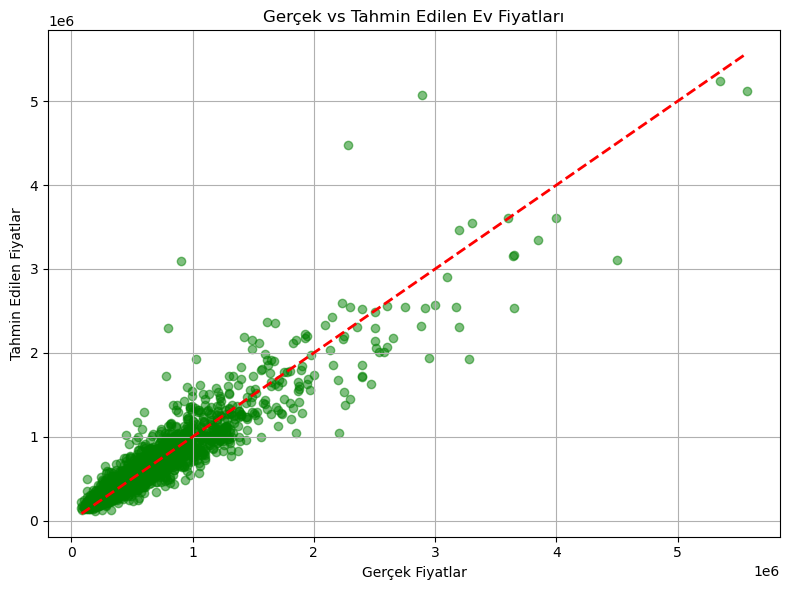

In [7]:
# Hiperparametre Optimizasyonu
# En Başta Yaptığımda Gradyan Arttırma çıktı sonra önişlemeyi detaylandırınca rastgele orman çıktığı için iki if ile ele aldım .
from sklearn.model_selection import RandomizedSearchCV
print(f"\n🚀 En iyi model: {best_model_name} (R2: {results[best_model_name]['R2']:.4f})")
print(f"🥈 İkinci en iyi: {second_best_name} (R2: {results[second_best_name]['R2']:.4f})")
print(f"   • Rastgele Orman: Daha çok optimize ederken kötüleştiriyor")
print(f"   • Gradyan: Arttırma: Optimize ederken iyileştiriyor ")
print(f"💡 : Bu Yüzden ben Gradyan Arttırma ile devam ediyorum.")
# En iyi modeli gradyan arttırma olarak değiştir 
best_model_name="Gradyan Arttırma"
# En iyi modelin Hiperparametrelerini optimize etme
if best_model_name == "Gradyan Arttırma":
    # Uzayını tanımlama
    param_dist = {
        'n_estimators': [50, 100, 150, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'max_depth': [3, 4, 5, 6, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0],
        'max_features': ['sqrt', 'log2']
    }
    # RandomizedSearchCV nesnesi oluşturun
    random_search = RandomizedSearchCV(
        estimator=GradientBoostingRegressor(random_state=42),
        param_distributions=param_dist,
        n_iter=25,  # 25 farklı kombinasyon deneyin (bu sayıyı değiştirebilirsiniz)
        cv=3,       # 3-katlı çapraz doğrulama
        scoring='neg_mean_squared_error',
        n_jobs=-1,  # Tüm CPU çekirdeklerini kullanır
        random_state=42,
        verbose=1   # İlerleme durumunu gösterir
    )

    # Eğitimi başlatın
    print("RandomizedSearchCV başlatılıyor...")
    start_time = time.time()
    random_search.fit(X_train_scaled, y_train)
    training_duration = time.time() - start_time

    # En iyi parametreleri ve skoru görüntüleyin
    print("\nEn iyi parametreler:", random_search.best_params_)
    print("En iyi negatif MSE skoru:", random_search.best_score_)
    best_rmse = np.sqrt(-random_search.best_score_)
    print(f"En iyi RMSE: {best_rmse:.2f}")

    # En iyi modeli alıp test setinde değerlendirin
    best_model = random_search.best_estimator_
    y_pred_best = best_model.predict(X_test_scaled)

    # Final sonuçlarını hesaplayın
    mae_best = mean_absolute_error(y_test, y_pred_best)
    mse_best = mean_squared_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test, y_pred_best)
    cv_r2_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=3, scoring='r2')
    cv_r2_mean = np.mean(cv_r2_scores)
    cv_r2_std = np.std(cv_r2_scores)
    optimized_metrics = {
    'MAE': mae_best,
    'MSE': mse_best,
    'RMSE': rmse_best,
    'R2': r2_best,
    'CV R2 (Ortalama)': cv_r2_mean,
    'CV R2 (Std Sapma)': cv_r2_std,
    'Eğitim Süresi (s)': training_duration
    }
    print(f"\nOptimize edilmiş Gradyan Artırma - MAE: {mae_best:.2f}, RMSE: {rmse_best:.2f}, R2: {r2_best:.4f}")
    #Tablo Oluşturup yazma 
    print("\n=== KARŞILAŞTIRMA TABLOSU ===")

    df_compare = pd.DataFrame({
        'Önceki Model': previous_metrics,
        'Optimize Edilmiş Model': optimized_metrics
    })

    df_compare['İyileşme (%)'] = ((df_compare['Optimize Edilmiş Model'] - df_compare['Önceki Model']) / df_compare['Önceki Model']) * 100

    for metric in ['MAE', 'MSE', 'RMSE']:
        df_compare.loc[metric, 'İyileşme (%)'] *= -1
    pd.set_option('display.float_format', '{:,.2f}'.format)  
    # Display yerine print kullan
    print(df_compare.round(2))
    
    # Tahminin Başarı Grafiği (DÜZELTME: y_pred_best kullan)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.5, color='green')  # y_pred_best kullan
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel("Gerçek Fiyatlar")
    plt.ylabel("Tahmin Edilen Fiyatlar")
    plt.title("Gerçek vs Tahmin Edilen Ev Fiyatları")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

elif best_model_name == "Rastgele Orman":
    # Uzayını tanımlama
    param_dist = {
        'n_estimators': [100, 200, 300,],
        'max_depth': [10, 15, 20, 25,50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }
    random_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42, n_jobs=-1),  # DOĞRU estimator
        param_distributions=param_dist,
        n_iter=50,
        cv=3,
        scoring='r2', 
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    # Eğitimi başlatın
    print("RandomizedSearchCV başlatılıyor...")
    random_search.fit(X_train, y_train)

    # En iyi parametreleri ve skoru görüntüleyin
    print("\nEn iyi parametreler:", random_search.best_params_)
    print("En iyi R2 skoru:", random_search.best_score_)

    # En iyi modeli alıp test setinde değerlendirin
    best_model = random_search.best_estimator_
    y_pred_best = best_model.predict(X_test)

    # Final sonuçlarını hesaplayın
    mae_best = mean_absolute_error(y_test, y_pred_best)
    mse_best = mean_squared_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test, y_pred_best)
    optimized_metrics = {
    'MAE': mae_best,
    'MSE': mse_best,
    'RMSE': rmse_best,
    'R2': r2_best
    }
    print(f"\nOptimize edilmiş Rastgele Orman - MAE: {mae_best:.2f}, RMSE: {rmse_best:.2f}, R2: {r2_best:.4f}")
    #Tablo Oluşturup yazma 
    print("\n=== KARŞILAŞTIRMA TABLOSU ===")

    df_compare = pd.DataFrame({ 
        'Önceki Model': previous_metrics,
        'Optimize Edilmiş Model': optimized_metrics
    })

    df_compare['İyileşme (%)'] = ((df_compare['Optimize Edilmiş Model'] - df_compare['Önceki Model']) / df_compare['Önceki Model']) * 100

    for metric in ['MAE', 'MSE', 'RMSE']:
        df_compare.loc[metric, 'İyileşme (%)'] *= -1

    # Display yerine print kullan
    print(df_compare.round(2))
    
    # Tahminin Başarı Grafiği
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.5, color='green')  
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel("Gerçek Fiyatlar")
    plt.ylabel("Tahmin Edilen Fiyatlar")
    plt.title("Gerçek vs Tahmin Edilen Ev Fiyatları")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
def predict_house_price(sqft_living, bedrooms, bathrooms, grade, year_built):
    """Gerçek hayat senaryosu için tahmin fonksiyonu"""
    
    sample_data = pd.DataFrame({
        'bedrooms': [bedrooms],
        'bathrooms': [bathrooms], 
        'sqft_living': [sqft_living],
        'sqft_lot': [7500],
        'floors': [1.0],
        'waterfront': [0],
        'view': [0],
        'condition': [3],
        'grade': [grade],
        'sqft_above': [int(sqft_living * 0.8)],
        'sqft_basement': [int(sqft_living * 0.2)],
        'yr_built': [year_built],
        'yr_renovated': [0],
        'lat': [47.5],
        'long': [-122.3],
        'sqft_living15': [sqft_living],
        'sqft_lot15': [7500],
        'year': [2023],
        'month': [5],
        'day': [15],
        'house_age': [2023 - year_built],
        'sqft_per_room': [sqft_living / (bedrooms + bathrooms + 1)],
        'living_lot_ratio': [sqft_living / 7500],
        'above_total_ratio': [0.8],
        'is_renovated': [0],
        'premium_location': [0],
        'house_size': [2 if sqft_living < 2500 else 3],
        'floors_ratio': [1.0 / sqft_living * 1000]
    })
    
    # Model tipine göre tahmin
    if best_model_name == "Gradyan Arttırma":
        sample_scaled = scaler.transform(sample_data)
        prediction = best_model.predict(sample_scaled)
    else:  # Random Forest
        prediction = best_model.predict(sample_data)
    
    return prediction[0]


🏠 ÖRNEK EV TAHMİNLERİ:
Küçük ev: $268,643
Orta ev: $387,369
Büyük ev: $732,896
Lüks ev: $2,025,636

--- ÖZELLİK ÖNEMİ ANALİZİ ---


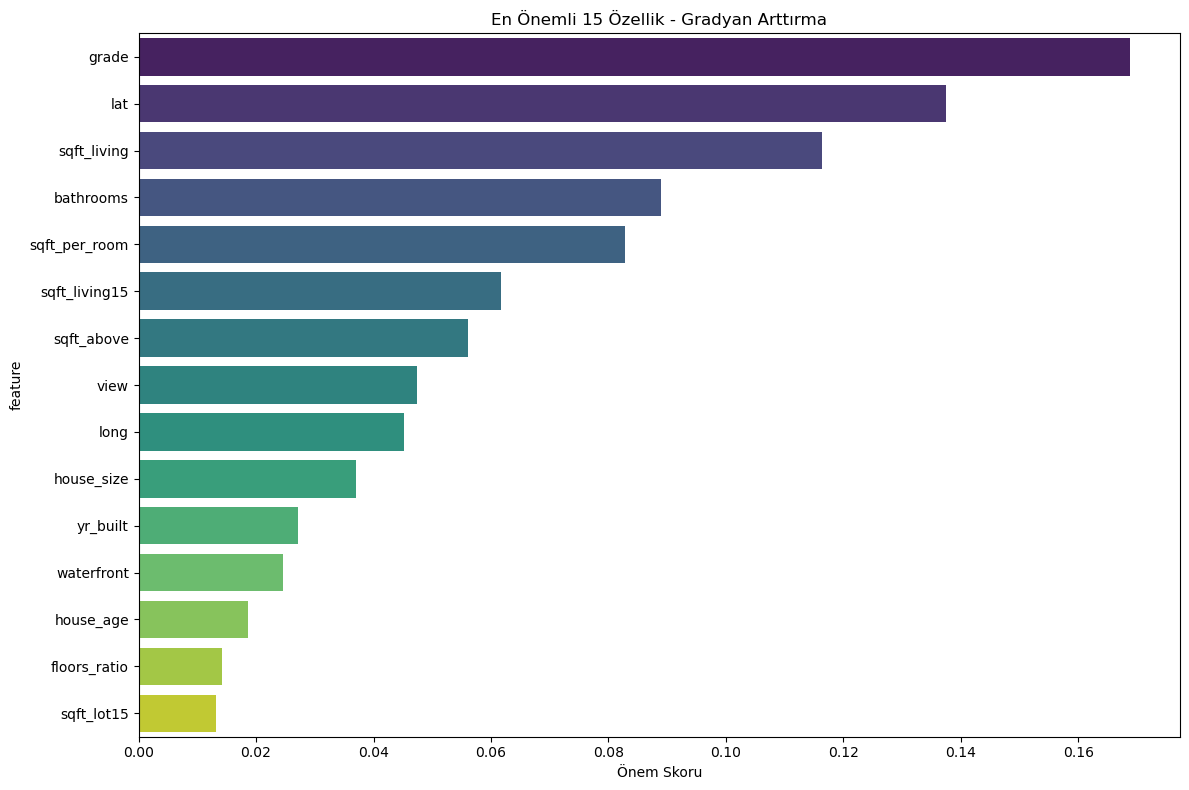


En önemli özellikler (Gradyan Arttırma):
grade               : 0.1689
lat                 : 0.1376
sqft_living         : 0.1164
bathrooms           : 0.0890
sqft_per_room       : 0.0829
sqft_living15       : 0.0618
sqft_above          : 0.0561
view                : 0.0474
long                : 0.0453
house_size          : 0.0370

--- PERFORMANS ANALİZİ ---


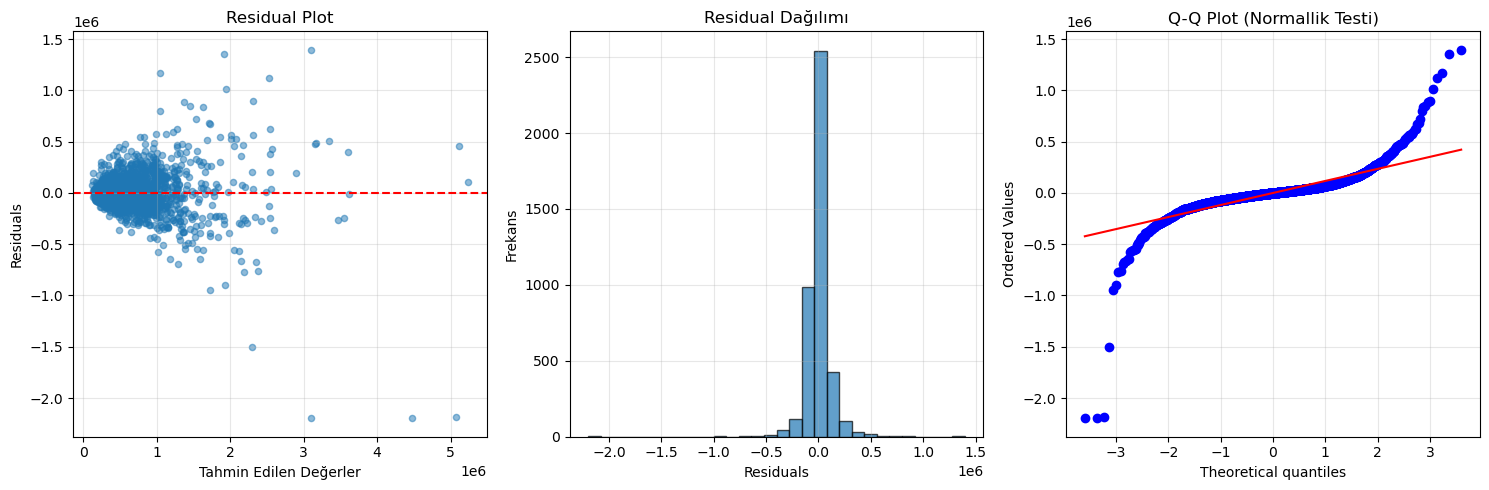

In [9]:
# Örnek kullanım
print("\n🏠 ÖRNEK EV TAHMİNLERİ:")

test_cases = [
    (1500, 2, 1, 6, 2000, "Küçük ev"),
    (2000, 3, 2, 8, 1990, "Orta ev"),
    (3500, 4, 3, 10, 2010, "Büyük ev"),
    (5000, 5, 4, 12, 2015, "Lüks ev")
]

for sqft, bed, bath, grade, year, desc in test_cases:
    try:
        price = predict_house_price(sqft, bed, bath, grade, year)
        print(f"{desc}: ${price:,.0f}")
    except Exception as e:
        print(f"{desc}: Tahmin hatası - {e}")

# FEATURE IMPORTANCE
print("\n--- ÖZELLİK ÖNEMİ ANALİZİ ---")

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance',hue='feature' , y='feature', palette='viridis')
plt.title(f'En Önemli 15 Özellik - {best_model_name}')
plt.xlabel('Önem Skoru')
plt.tight_layout()
plt.show()

print(f"\nEn önemli özellikler ({best_model_name}):")
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:20}: {row['importance']:.4f}")

# MODEL PERFORMANS VİZÜALİZASYONU
print("\n--- PERFORMANS ANALİZİ ---")

residuals = y_test - y_pred_best
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_pred_best, residuals, alpha=0.5, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Tahmin Edilen Değerler')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frekans')
plt.title('Residual Dağılımı')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normallik Testi)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()